<h1 style="text-align:center;">COSC 6364 Final Project</h1>

<h2 style="text-align:center;">Assessing the effectiveness of an emergency sound recognition system utilizing frequency centric signal processing</h2>



## Import required libraries

In [1]:
#Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import sys
from scipy.signal import fftconvolve
import pandas as pd
import random
import cv2
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import * 
import seaborn as sns

## Define helper functions to perform some basic signal processing on audio files and analyze their frequency content.

In [2]:
# This function is used to pad the input data with zeros to the nearest power of two in order to optimize the FFT algorithm
def padding(list):
  k = 0
  while 2**k < len(list):
    k = k+1
  return np.concatenate((list,([0]*(2**k-len(list)))))

In [3]:
# This function computes the DFT of the input data.
def dft(data):
  data = np.asarray(data, dtype=float)
  N = data.shape[0] 
  n = np.arange (N)
  k = n.reshape((N, 1))
  M = np.exp(-2j*np.pi*k * n / N)
  return np.dot (M, data)

In [4]:
# This function recursively computes the FFT of the input data by dividing it into even and odd halves
def fft(data):
  data=padding(data)
  data = np.asarray(data, dtype=float)
  n = data.shape[0] 
  if n <= 32: 
    return dft (data)
  else:
    odd = fft(data[1::2]) 
    even = fft (data[::2])
    factor = np.exp(-2j*np.pi*np.arange(n)/n)
    return np.concatenate([even + factor[:n // 2] * odd,even + factor[n// 2:]*odd])

### Visualize the FFT and Convolution of Emergency Audio Signal with itself and Non-Emergency Signal

In [5]:
# load the emergency sound data and compute fft
rate_emerg, data_emerg = wavfile.read("sound_1.wav") 
sig_emerg = data_emerg.T[0]
emerg_fft = fft(sig_emerg)
emerg_fft_len = len(emerg_fft)//2

In [6]:
# load the non-emergency sound data and compute fft
rate_non_emerg, data_non_emerg = wavfile.read("sound_401.wav")
sig_non_emerg = data_non_emerg.T[0] 
non_emerg_fft = fft(sig_non_emerg)
non_emerg_fft_len = len(non_emerg_fft)//2 

In [7]:
#Perform convolution on emergency signal with itself
convolve_emerg = fftconvolve(sig_emerg, sig_emerg[::-1], mode='same')
ce = convolve_emerg*np.conj(convolve_emerg)

#Perform convolution on emergency signal with non-emergency signal
convolve_emerg = fftconvolve(sig_non_emerg, sig_emerg[::-1], mode='same')
cne = convolve_emerg*np.conj(convolve_emerg)

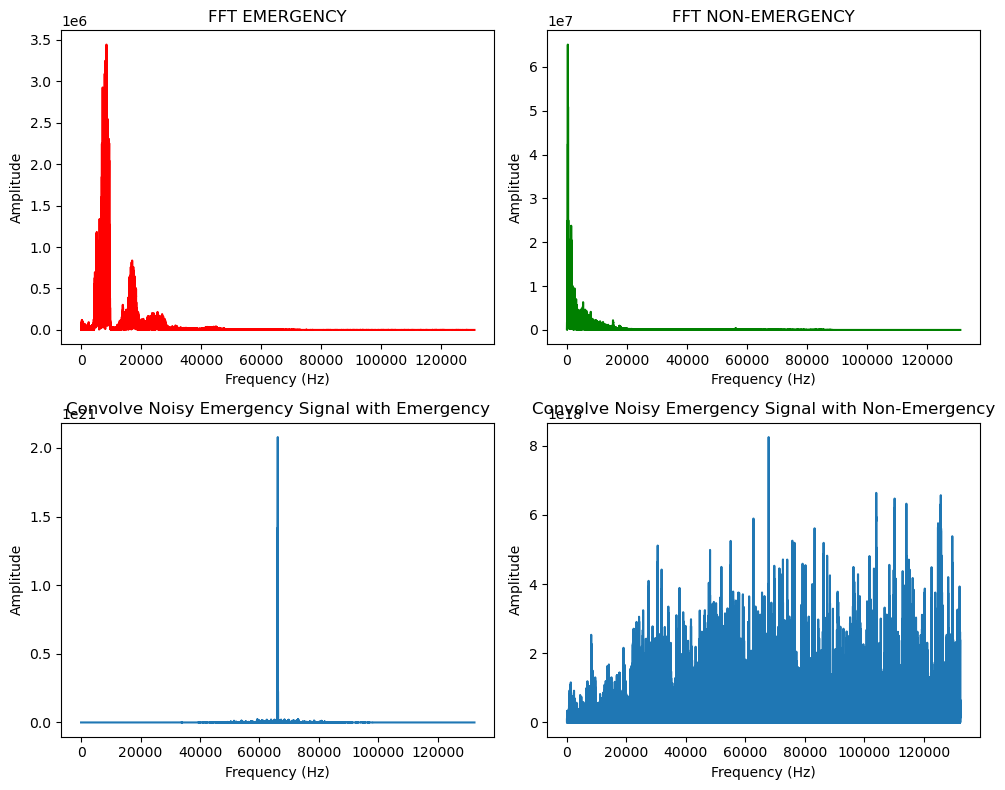

In [8]:
#Draw the plots for FFT and Signal Convolutions
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes[0, 0].plot(abs(emerg_fft[:(emerg_fft_len-1)]),'r')
axes[0, 0].set_title('FFT EMERGENCY')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Amplitude')

axes[0, 1].plot(abs(non_emerg_fft[:(non_emerg_fft_len-1)]),'g')
axes[0, 1].set_title('FFT NON-EMERGENCY')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Amplitude')

axes[1, 0].plot(ce)
axes[1, 0].set_title('Convolve Noisy Emergency Signal with Emergency')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Amplitude')

axes[1, 1].plot(cne)
axes[1, 1].set_title('Convolve Noisy Emergency Signal with Non-Emergency')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Amplitude')

fig.tight_layout()
plt.show()


In [9]:
print(len(sig_emerg))

132300


### Visualize the Original and Mixed/Noisy Signals 

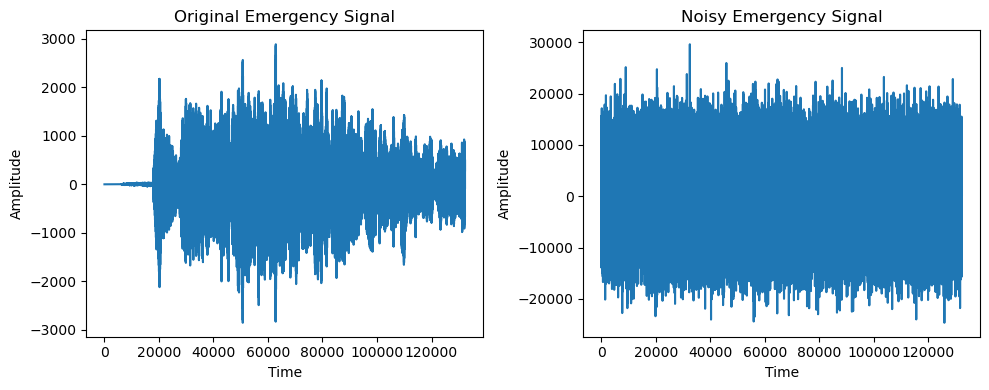

In [10]:
signal = np.random.normal(0,1,132300)
signal = signal[:132300]
mixed = signal*6000+sig_emerg

# create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# plot the first subplot in the first row
axs[0].plot(sig_emerg)
axs[0].set_title('Original Emergency Signal')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

# plot the second subplot in the first row
axs[1].plot(mixed)
axs[1].set_title('Noisy Emergency Signal')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')

# adjust the spacing between subplots to prevent overlapping of titles and labels
plt.tight_layout()

# show the plot
plt.show()


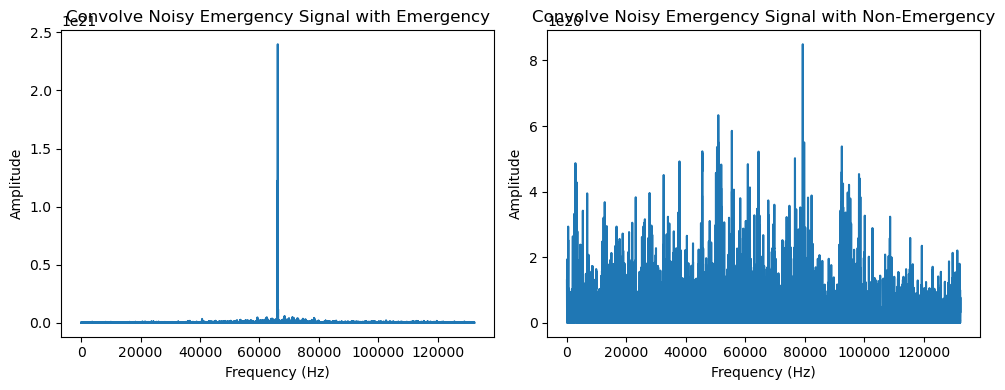

In [11]:
# convolve the mixed signal with the emergency signal
convolve_emerg = fftconvolve(mixed, sig_emerg[::-1], mode='same')
ce_emerg = convolve_emerg * np.conj(convolve_emerg)

# convolve the mixed signal with the non-emergency signal
convolve_non_emerg = fftconvolve(mixed, sig_non_emerg[::-1], mode='same')
ce_non_emerg = convolve_non_emerg * np.conj(convolve_non_emerg)

# create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# plot the first subplot in the first column
axs[0].plot(ce_emerg)
axs[0].set_title('Convolve Noisy Emergency Signal with Emergency')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Amplitude')

# plot the second subplot in the second column
axs[1].plot(ce_non_emerg)
axs[1].set_title('Convolve Noisy Emergency Signal with Non-Emergency')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Amplitude')

# adjust the spacing between subplots to prevent overlapping of titles and labels
plt.tight_layout()

# show the plot
plt.show()


In [12]:
DATASET_LOCATION = "dataset/train_images/"
import os
filenames = os.listdir(DATASET_LOCATION)

classes = []
for filename in filenames:
    image_class = filename[0:3]
    if image_class == "eme":
        classes.append(0)
    else:
        classes.append(1)
print(classes[:5])

[0, 0, 0, 0, 0]


In [13]:
print(filenames)

df = pd.DataFrame({"filename": filenames, "category": classes})

df["category"] = df["category"].replace({1: "non_emergency", 0: "emergency"})

df.head(-5)


['emergency_1.jpg', 'emergency_10.jpg', 'emergency_100.jpg', 'emergency_101.jpg', 'emergency_102.jpg', 'emergency_103.jpg', 'emergency_104.jpg', 'emergency_105.jpg', 'emergency_106.jpg', 'emergency_107.jpg', 'emergency_108.jpg', 'emergency_109.jpg', 'emergency_11.jpg', 'emergency_110.jpg', 'emergency_111.jpg', 'emergency_112.jpg', 'emergency_113.jpg', 'emergency_114.jpg', 'emergency_115.jpg', 'emergency_116.jpg', 'emergency_117.jpg', 'emergency_118.jpg', 'emergency_119.jpg', 'emergency_12.jpg', 'emergency_120.jpg', 'emergency_121.jpg', 'emergency_122.jpg', 'emergency_123.jpg', 'emergency_124.jpg', 'emergency_125.jpg', 'emergency_126.jpg', 'emergency_127.jpg', 'emergency_128.jpg', 'emergency_129.jpg', 'emergency_13.jpg', 'emergency_130.jpg', 'emergency_131.jpg', 'emergency_132.jpg', 'emergency_133.jpg', 'emergency_134.jpg', 'emergency_135.jpg', 'emergency_136.jpg', 'emergency_137.jpg', 'emergency_138.jpg', 'emergency_139.jpg', 'emergency_14.jpg', 'emergency_140.jpg', 'emergency_141.jpg'

,filename,category
0,emergency_1.jpg,emergency
1,emergency_10.jpg,emergency
2,emergency_100.jpg,emergency
3,emergency_101.jpg,emergency
4,emergency_102.jpg,emergency
...,...,...
390,non_emergency_90.jpg,non_emergency
391,non_emergency_91.jpg,non_emergency
392,non_emergency_92.jpg,non_emergency
393,non_emergency_93.jpg,non_emergency


### Visualize the Spectograms of Emergency and Non-emergency Audio Signal

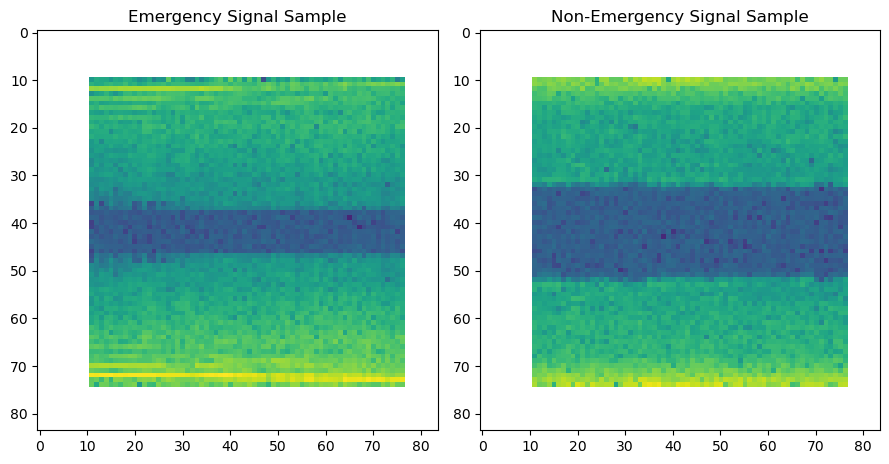

In [14]:
# read the images
emergency_image = cv2.imread(DATASET_LOCATION + "/emergency_99.jpg" )
non_emergency_image = cv2.imread(DATASET_LOCATION + "/non_emergency_99.jpg")

# create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 8))

# plot the first image in the first subplot
axs[0].imshow(cv2.cvtColor(emergency_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Emergency Signal Sample')

# plot the second image in the second subplot
axs[1].imshow(cv2.cvtColor(non_emergency_image, cv2.COLOR_BGR2RGB))
axs[1].set_title('Non-Emergency Signal Sample')

# adjust the spacing between subplots to prevent overlapping of titles and labels
plt.tight_layout()

# show the plot
plt.show()


## Build a CNN Model to detect the emergency audio signal

In [15]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [16]:
#Custom built Model with combination of Conv2D, Maxpooling, Dense layers
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu",input_shape=INPUT_SHAPE))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(2, activation="sigmoid"))
model.compile(
    loss=keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7372928   
                                                        

In [17]:
# Create the test and validation dataset out of the original images using train_test_split module
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)

In [18]:
len(test_df)

80

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

BATCH_SIZE = 16

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    val_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=42
)

test_generator = train_datagen.flow_from_dataframe(
    test_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=1,
    color_mode="rgb",
    seed=42
)

Found 256 validated image filenames belonging to 2 classes.
Found 64 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.


In [20]:
EPOCHS = 15
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=test_df.shape[0] // BATCH_SIZE,
    steps_per_epoch=train_df.shape[0] // BATCH_SIZE,
)

Epoch 1/15


C:\Users\qasim\AppData\Local\Temp\ipykernel_30896\1214772301.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


16/16 [==============================] - 4s 200ms/step - loss: 1.0432 - accuracy: 0.4883 - val_loss: 0.6945 - val_accuracy: 0.4219
Epoch 2/15
16/16 [==============================] - 2s 123ms/step - loss: 0.6400 - accuracy: 0.6992
Epoch 3/15
16/16 [==============================] - 2s 122ms/step - loss: 0.4162 - accuracy: 0.8867
Epoch 4/15
16/16 [==============================] - 2s 121ms/step - loss: 0.1923 - accuracy: 0.9375
Epoch 5/15
16/16 [==============================] - 2s 120ms/step - loss: 0.0666 - accuracy: 0.9805
Epoch 6/15
16/16 [==============================] - 2s 121ms/step - loss: 0.0392 - accuracy: 0.9883
Epoch 7/15
16/16 [==============================] - 2s 120ms/step - loss: 0.0523 - accuracy: 0.9805
Epoch 8/15
16/16 [==============================] - 2s 121ms/step - loss: 0.0265 - accuracy: 0.9961
Epoch 9/15
16/16 [==============================] - 2s 122ms/step - loss: 0.0195 - accuracy: 0.9922
Epoch 10/15
16/16 [==============================] - 2s 124ms/step - 

In [21]:
loss, accuracy = model.evaluate(test_generator)
print("Test set accuracy of the model:", accuracy*100, "%")

80/80 [==============================] - 1s 8ms/step - loss: 0.0022 - accuracy: 1.0000
Test set accuracy of the model: 100.0 %


In [22]:
xt = 0
y_test = []
prediction = []
images = []

for i in test_generator:
  p = np.argmax(model.predict(i[0]), axis=-1)[0]
  a = np.argmax(i[1], axis=-1)[0]
  y_test.append(a)
  prediction.append(p)
  images.append(i[0][0])
  xt+=1
  if xt==80:
    break

1/1 [==============================] - 0s 24ms/step


In [23]:
images2 = images.copy()
y_test2 = y_test.copy()
images = images.copy()
y_test = y_test.copy()

In [24]:
print(accuracy_score(y_test, prediction))

1.0


In [25]:
precision = precision_score(y_test, prediction)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, prediction)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, prediction)
print('F1 score: %f' % f1)

Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


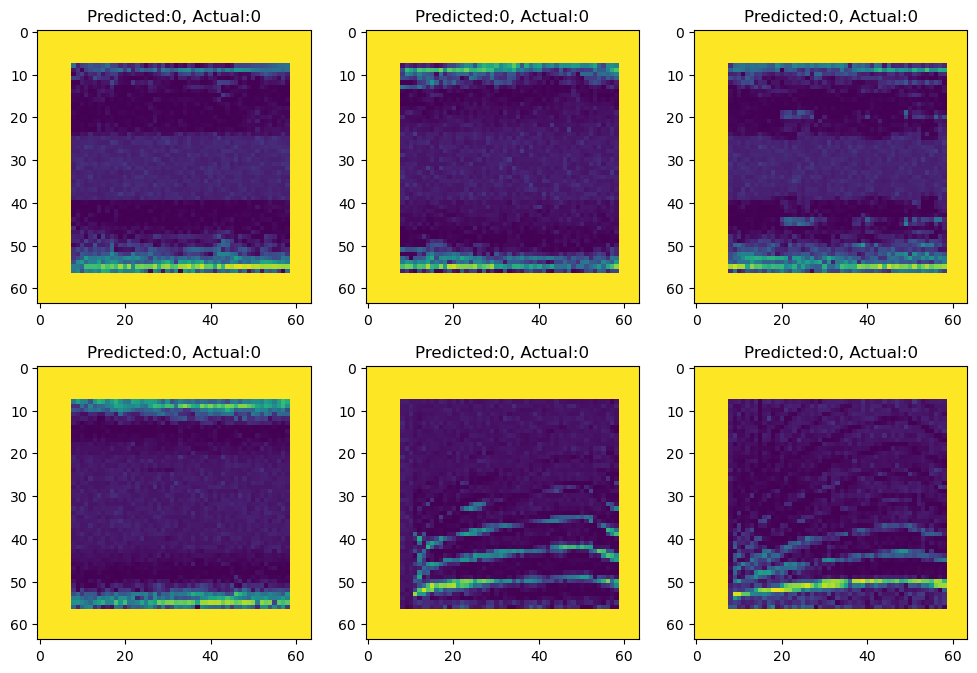

In [26]:
plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.title(("Predicted:{}, Actual:{}").format(prediction[i],y_test[i]))
    plt.imshow(images[i][:,:,0])

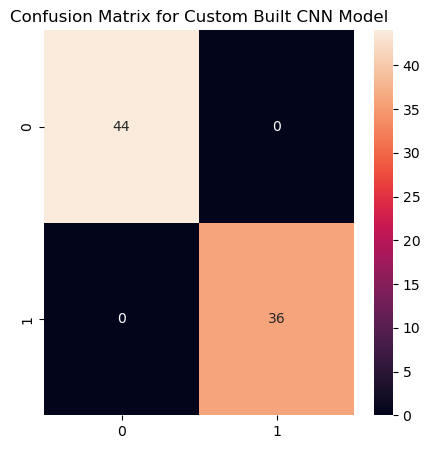

In [27]:
#Plot the confusion matrix for Custom Model

# Set the colormap
cmap = 'coolwarm'

plt.rcParams['figure.figsize'] = 5, 5
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix for Custom Built CNN Model')
sns.heatmap(confusion_matrix(y_test, prediction), annot=True)
plt.show()

In [28]:
def add_noise(image, percent):
    gauss = np.random.normal(0,1,(image.shape))
    gauss = gauss.reshape(image.shape)
    noisy = image + (gauss*percent/100)
    return noisy


In [29]:
noise_levels = [0, 5, 15, 25, 35]
accuracy = []
for n in noise_levels:
  xt = 0
  y_test3 = []
  prediction3 = []
  images = []

  for i in test_generator:
    i[0][0] = add_noise(i[0][0],n)
    p = np.argmax(model.predict(i[0]), axis=-1)[0]
    a = np.argmax(i[1], axis=-1)[0]
    y_test3.append(a)
    prediction3.append(p)
    xt+=1
    if xt==80:
      break
  accuracy.append(accuracy_score(y_test3, prediction3))

1/1 [==============================] - 0s 26ms/step


In [30]:
accuracy_with_noise = [x * 100 for x in accuracy]

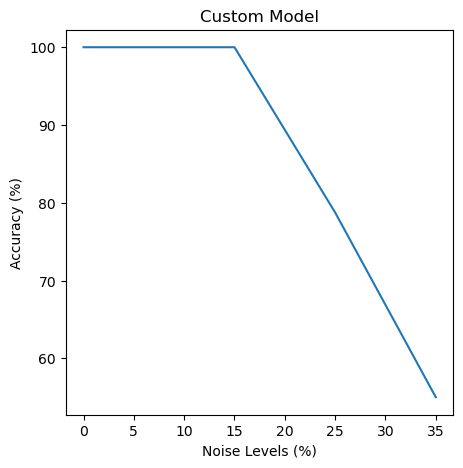

In [31]:
plt.plot(noise_levels, accuracy_with_noise) 
plt.title('Custom Model')
plt.xlabel('Noise Levels (%)')
plt.ylabel('Accuracy (%)')
plt.show()

In [32]:
for i, j in zip(noise_levels,accuracy_with_noise):
  print('Accuracy at Noise Level {}% is {}%'.format(i, round(j,2)))


Accuracy at Noise Level 0% is 100.0%
Accuracy at Noise Level 5% is 100.0%
Accuracy at Noise Level 15% is 100.0%
Accuracy at Noise Level 25% is 78.75%
Accuracy at Noise Level 35% is 55.0%


## Retrain Data with smaller training set

In [33]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.80, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)

from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

BATCH_SIZE = 16

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    val_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=42
)

test_generator = train_datagen.flow_from_dataframe(
    test_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=1,
    color_mode="rgb",
    seed=42
)

EPOCHS = 15

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,

    validation_steps=test_df.shape[0] // BATCH_SIZE,

    steps_per_epoch=train_df.shape[0] // BATCH_SIZE,

)

Found 64 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Epoch 1/15


C:\Users\qasim\AppData\Local\Temp\ipykernel_30896\425113232.py:57: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


4/4 [==============================] - 1s 162ms/step - loss: 5.8012e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/15
4/4 [==============================] - 1s 129ms/step - loss: 3.8851e-04 - accuracy: 1.0000
Epoch 3/15
4/4 [==============================] - 1s 126ms/step - loss: 4.1116e-04 - accuracy: 1.0000
Epoch 4/15
4/4 [==============================] - 1s 124ms/step - loss: 2.6328e-04 - accuracy: 1.0000
Epoch 5/15
4/4 [==============================] - 1s 131ms/step - loss: 1.5711e-04 - accuracy: 1.0000
Epoch 6/15
4/4 [==============================] - 1s 128ms/step - loss: 2.6554e-04 - accuracy: 1.0000
Epoch 7/15
4/4 [==============================] - 1s 124ms/step - loss: 1.8320e-04 - accuracy: 1.0000
Epoch 8/15
4/4 [==============================] - 1s 127ms/step - loss: 3.7036e-04 - accuracy: 1.0000
Epoch 9/15
4/4 [==============================] - 1s 122ms/step - loss: 2.2192e-04 - accuracy: 1.0000
Epoch 10/15
4/4 [==============================] - 

In [34]:
xt = 0
y_test = []
prediction = []
images = []

for i in test_generator:
  p = np.argmax(model.predict(i[0]), axis=-1)[0]
  a = np.argmax(i[1], axis=-1)[0]
  y_test.append(a)
  prediction.append(p)
  images.append(i[0][0])
  xt+=1
  if xt==80:
    break

1/1 [==============================] - 0s 24ms/step


In [35]:
print(accuracy_score(y_test, prediction))

1.0


# Pre-trained Models

## VGG 16 Model

In [36]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False

In [37]:
flatten_layer = layers.Flatten()
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_2,
    prediction_layer
])

In [38]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)

from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

BATCH_SIZE = 16

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    val_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=42
)

test_generator = train_datagen.flow_from_dataframe(
    test_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=1,
    color_mode="rgb",
    seed=42
)

model.compile(
    loss=keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"],
)

EPOCHS = 15

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,

    validation_steps=test_df.shape[0] // BATCH_SIZE,

    steps_per_epoch=train_df.shape[0] // BATCH_SIZE,

)

Found 256 validated image filenames belonging to 2 classes.
Found 64 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Epoch 1/15


C:\Users\qasim\AppData\Local\Temp\ipykernel_30896\883491752.py:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


16/16 [==============================] - 3s 171ms/step - loss: 0.7194 - accuracy: 0.5312 - val_loss: 0.7692 - val_accuracy: 0.4219
Epoch 2/15
16/16 [==============================] - 2s 125ms/step - loss: 0.6727 - accuracy: 0.6211
Epoch 3/15
16/16 [==============================] - 2s 126ms/step - loss: 0.6150 - accuracy: 0.7148
Epoch 4/15
16/16 [==============================] - 2s 124ms/step - loss: 0.5833 - accuracy: 0.8359
Epoch 5/15
16/16 [==============================] - 2s 124ms/step - loss: 0.5584 - accuracy: 0.7812
Epoch 6/15
16/16 [==============================] - 2s 124ms/step - loss: 0.5251 - accuracy: 0.8125
Epoch 7/15
16/16 [==============================] - 2s 125ms/step - loss: 0.5036 - accuracy: 0.8438
Epoch 8/15
16/16 [==============================] - 2s 126ms/step - loss: 0.4690 - accuracy: 0.8359
Epoch 9/15
16/16 [==============================] - 2s 126ms/step - loss: 0.4581 - accuracy: 0.8750
Epoch 10/15
16/16 [==============================] - 2s 125ms/step - 

In [39]:
loss, accuracy = model.evaluate(test_generator)

80/80 [==============================] - 2s 22ms/step - loss: 0.3650 - accuracy: 0.8625


In [40]:
xt = 0
y_test = []
prediction = []
images = []

for i in test_generator:
  p = np.argmax(model.predict(i[0]), axis=-1)[0]
  a = np.argmax(i[1], axis=-1)[0]
  y_test.append(a)
  prediction.append(p)
  images.append(i[0][0])
  xt+=1
  if xt==80:
    break


1/1 [==============================] - 0s 38ms/step


In [41]:
print(accuracy_score(y_test, prediction))

0.8625


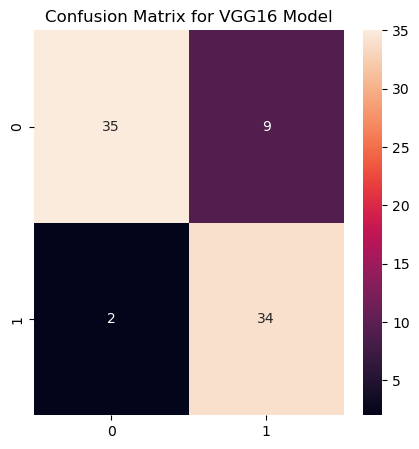

In [42]:
#Plot the confusion matrix for VGG16

# Set the colormap
cmap = 'coolwarm'

plt.rcParams['figure.figsize'] = 5, 5
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix for VGG16 Model')
sns.heatmap(confusion_matrix(y_test, prediction), annot=True)
plt.show()

In [43]:
noise_levels = [0, 5, 15, 25, 35]
accuracy = []
for n in noise_levels:
  xt = 0
  y_test3 = []
  prediction3 = []
  images = []

  for i in test_generator:
    i[0][0] = add_noise(i[0][0],n)
    p = np.argmax(model.predict(i[0]), axis=-1)[0]
    a = np.argmax(i[1], axis=-1)[0]
    y_test3.append(a)
    prediction3.append(p)
    xt+=1
    if xt==80:
      break
  accuracy.append(accuracy_score(y_test3, prediction3))

1/1 [==============================] - 0s 41ms/step


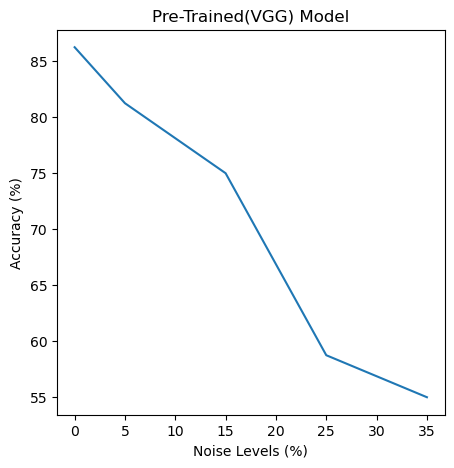

In [44]:
accuracy_with_noise_vgg = [x * 100 for x in accuracy]

plt.plot(noise_levels, accuracy_with_noise_vgg) 
plt.title('Pre-Trained(VGG) Model')
plt.xlabel('Noise Levels (%)')
plt.ylabel('Accuracy (%)')
plt.show()

In [45]:
accuracy_with_noise_vgg

[86.25, 81.25, 75.0, 58.75, 55.00000000000001]

# ResNet50 Model

In [46]:
base_model_resNet = ResNet50(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
base_model_resNet.trainable = False

In [47]:
flatten_layer = layers.Flatten()
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')

model = models.Sequential([
    base_model_resNet,
    flatten_layer,
    dense_layer_2,
    prediction_layer
])

In [48]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)


from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

BATCH_SIZE = 16

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    val_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=42
)

test_generator = train_datagen.flow_from_dataframe(
    test_df,
    DATASET_LOCATION,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=1,
    color_mode="rgb",
    seed=42
)

model.compile(
    loss=keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"],
)

EPOCHS = 15

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,

    validation_steps=test_df.shape[0] // BATCH_SIZE,

    steps_per_epoch=train_df.shape[0] // BATCH_SIZE,

)

Found 256 validated image filenames belonging to 2 classes.
Found 64 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Epoch 1/15


C:\Users\qasim\AppData\Local\Temp\ipykernel_30896\55655360.py:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


16/16 [==============================] - 6s 236ms/step - loss: 0.7205 - accuracy: 0.4883 - val_loss: 0.7691 - val_accuracy: 0.4219
Epoch 2/15
16/16 [==============================] - 2s 138ms/step - loss: 0.6987 - accuracy: 0.5352
Epoch 3/15
16/16 [==============================] - 2s 139ms/step - loss: 0.6890 - accuracy: 0.5352
Epoch 4/15
16/16 [==============================] - 2s 138ms/step - loss: 0.6899 - accuracy: 0.5391
Epoch 5/15
16/16 [==============================] - 2s 140ms/step - loss: 0.6898 - accuracy: 0.5352
Epoch 6/15
16/16 [==============================] - 2s 140ms/step - loss: 0.6873 - accuracy: 0.5352
Epoch 7/15
16/16 [==============================] - 2s 138ms/step - loss: 0.6873 - accuracy: 0.5352
Epoch 8/15
16/16 [==============================] - 2s 139ms/step - loss: 0.6870 - accuracy: 0.5352
Epoch 9/15
16/16 [==============================] - 2s 140ms/step - loss: 0.6845 - accuracy: 0.5352
Epoch 10/15
16/16 [==============================] - 2s 139ms/step - 

In [49]:
loss, accuracy = model.evaluate(test_generator)

80/80 [==============================] - 2s 30ms/step - loss: 0.6978 - accuracy: 0.4750


In [50]:
xt = 0
y_test = []
prediction = []
images = []

for i in test_generator:
  p = np.argmax(model.predict(i[0]), axis=-1)[0]
  a = np.argmax(i[1], axis=-1)[0]
  y_test.append(a)
  prediction.append(p)
  images.append(i[0][0])
  xt+=1
  if xt==80:
    break


1/1 [==============================] - 0s 43ms/step


In [51]:
print(accuracy_score(y_test, prediction))

0.475


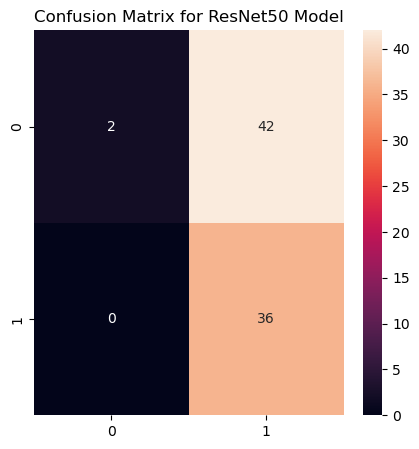

In [52]:
#Plot the confusion matrix for ResNet50

# Set the colormap
cmap = 'coolwarm'

plt.rcParams['figure.figsize'] = 5, 5
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix for ResNet50 Model')
sns.heatmap(confusion_matrix(y_test, prediction), annot=True)
plt.show()

In [53]:
noise_levels = [0, 5, 15, 25, 35]
accuracy = []
for n in noise_levels:
  xt = 0
  y_test3 = []
  prediction3 = []
  images = []

  for i in test_generator:
    i[0][0] = add_noise(i[0][0],n)
    p = np.argmax(model.predict(i[0]), axis=-1)[0]
    a = np.argmax(i[1], axis=-1)[0]
    y_test3.append(a)
    prediction3.append(p)
    xt+=1
    if xt==80:
      break
  accuracy.append(accuracy_score(y_test3, prediction3))

1/1 [==============================] - 0s 51ms/step


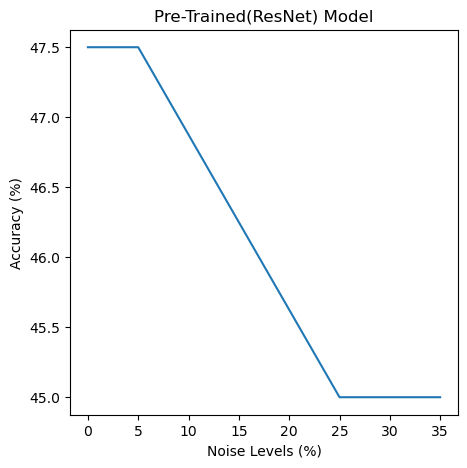

In [54]:
accuracy_with_noise_resNet = [x * 100 for x in accuracy]

plt.plot(noise_levels, accuracy_with_noise_resNet) 
plt.title('Pre-Trained(ResNet) Model')
plt.xlabel('Noise Levels (%)')
plt.ylabel('Accuracy (%)')
plt.show()

In [55]:
accuracy_with_noise_resNet

[47.5, 47.5, 46.25, 45.0, 45.0]

In [56]:
from tabulate import tabulate

# Define the data and noise levels
accuracy_with_noise
accuracy_with_noise_vgg
accuracy_with_noise_resNet
noise_levels = [0, 5, 15, 25, 35]

# Create a list of lists to hold the table data
table_data = []
for i in range(len(accuracy)):
    table_data.append([noise_levels[i], accuracy_with_noise[i], accuracy_with_noise_vgg[i], accuracy_with_noise_resNet[i]])

# Print the table using the tabulate function
print(tabulate(table_data, headers=['Noise Level', 'Accuracy with Custom Model', 'Accuracy with VGG16', 'Accuracy with ResNet50']))


  Noise Level    Accuracy with Custom Model    Accuracy with VGG16    Accuracy with ResNet50
-------------  ----------------------------  ---------------------  ------------------------
            0                        100                     86.25                     47.5
            5                        100                     81.25                     47.5
           15                        100                     75                        46.25
           25                         78.75                  58.75                     45
           35                         55                     55                        45


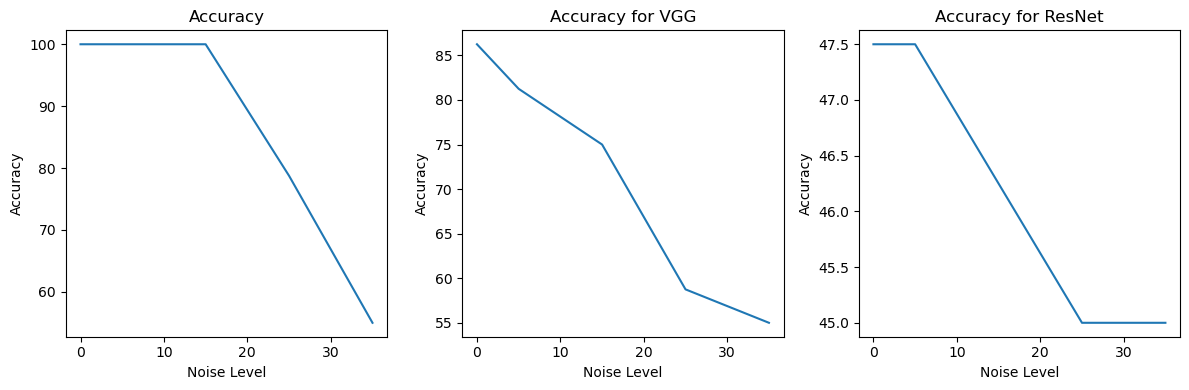

In [57]:
# Create a new figure
plt.figure(figsize=(12, 4))

# Plot the accuracies for the base model
plt.subplot(1, 3, 1)
plt.plot(noise_levels, accuracy_with_noise)
plt.title('Accuracy for Custom Model')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')

# Plot the accuracies for VGG
plt.subplot(1, 3, 2)
plt.plot(noise_levels, accuracy_with_noise_vgg)
plt.title('Accuracy for VGG')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')

# Plot the accuracies for ResNet
plt.subplot(1, 3, 3)
plt.plot(noise_levels, accuracy_with_noise_resNet)
plt.title('Accuracy for ResNet')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')

# Adjust the layout of the plots
plt.tight_layout()

# Display the figure
plt.show()